# Sentiment Analysis of IMDB Movie Reviews (Part 1: Exploratory Data Analysis)

**Problem Statement:**

In this, we have to predict the number of positive and negative reviews based on sentiments by using different classification models. We start with processing the data and explore the data through visualization.

Side note for profs: I have done NLP analysis before,so this work is using as a [this template](https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews/notebook) as a baseline. 

 


## Data Processing 
**Import necessary libraries**

In [81]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
# from textblob import TextBlob
# from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

**Import the training dataset**

In [82]:
#importing the training data
imdb_data=pd.read_csv('IMDB Dataset.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [83]:
#Summary of the dataset
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


**Sentiment count**

In [84]:
#sentiment count
imdb_data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

We can see that the dataset is balanced.

## Exploratory Data Analysis

/var/folders/0h/xyv81g2n7sj6zr0c9cw30gkc0000gn/T/ipykernel_9162/539831338.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(count_zeros,ax=ax1,color='Blue')
/var/folders/0h/xyv81g2n7sj6zr0c9cw30gkc0000gn/T/ipykernel_9162/539831338.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(count_ones

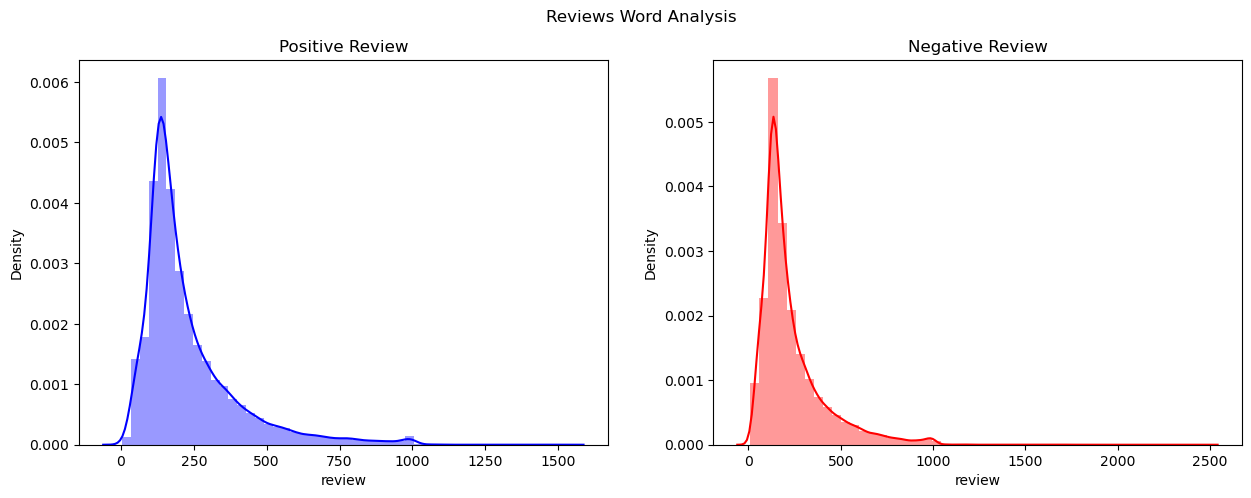

In [85]:
#Analyse the count of words in each segment- both positive and negative reviews
#Function for checking word length
def cal_len(data):
    return len(data)

#Create generic plotter with Seaborn
def plot_count(count_ones,count_zeros,title_1,title_2,subtitle):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    sns.distplot(count_zeros,ax=ax1,color='Blue')
    ax1.set_title(title_1)
    sns.distplot(count_ones,ax=ax2,color='Red')
    ax2.set_title(title_2)
    fig.suptitle(subtitle)
    plt.show()    


    
count_good=imdb_data[imdb_data['sentiment']=='positive']
count_bad=imdb_data[imdb_data['sentiment']=='negative']
count_good_words=count_good['review'].str.split().apply(lambda z:cal_len(z))
count_bad_words=count_bad['review'].str.split().apply(lambda z:cal_len(z))
# print("Positive Review Words:" + str(count_good_words))
# print("Negative Review Words:" + str(count_bad_words))
plot_count(count_good_words,count_bad_words,"Positive Review","Negative Review","Reviews Word Analysis")

Analyzing word count for positive and negative reviews, it seens that negative reviews have a much longer tails, which might result from angry viewers write long critics for bad movies. It shows us a potential of using word count to classify positive or negative sentiments. 

**Spliting the training dataset**

In [86]:
#split the dataset  
#train dataset
train_reviews=imdb_data.review[:40000]
train_sentiments=imdb_data.sentiment[:40000]
#test dataset
test_reviews=imdb_data.review[40000:]
test_sentiments=imdb_data.sentiment[40000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


**Removing html strips and noise text**

In [87]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)

/Users/swimmingcircle/opt/anaconda3/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


**Removing special characters**

In [88]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

**Text stemming**

In [89]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

**Removing stopwords**

In [90]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [91]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

{'most', 'or', "you've", 'so', "mightn't", 'not', 'that', 'while', 'against', 'wasn', 'myself', 'about', 'did', "she's", 'themselves', 'which', 'them', 'at', 'be', 'has', 'y', 'were', 'until', 'wouldn', 'doing', 'had', 'just', 'ourselves', "you'd", 'other', 'his', 'will', "should've", 'won', 'no', 'and', 'i', 'they', 'was', 'between', 'is', 'before', 'up', 'why', 'doesn', 'an', 'under', 'both', "aren't", 'below', 'again', 'ma', 'from', 'me', "hadn't", 'didn', 'll', 'it', "mustn't", 'by', 'above', 'with', 'a', "hasn't", 'those', 'in', 'are', 'hers', 'off', "won't", "shan't", 'through', 'such', 'the', 'if', 'now', 'she', "you'll", 't', "weren't", 'couldn', 'been', 'haven', 'only', 'shan', 'over', 'than', 'what', 'as', 'these', "needn't", 'isn', "wouldn't", 'mustn', "wasn't", 'o', "didn't", 'on', 'there', 'do', 'who', 'having', 'their', 'weren', 'more', 'once', 'yourselves', 'ain', 'of', 'am', "it's", 'very', 'all', 'should', 'any', 'own', 'after', 'itself', 'yourself', 'but', "haven't", 

**Normalized train reviews**

In [92]:
#normalized train reviews
norm_train_reviews=imdb_data.review[:40000]
norm_train_reviews[0]

'one review ha mention watch 1 oz episod youll hook right thi exactli happen meth first thing struck oz wa brutal unflinch scene violenc set right word go trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp

**Normalized test reviews**

In [93]:
#Normalized test reviews
norm_test_reviews=imdb_data.review[40000:]
norm_test_reviews[45005]

'read review watch thi piec cinemat garbag took least 2 page find somebodi els didnt think thi appallingli unfunni montag wasnt acm humour 70 inde ani era thi isnt least funni set sketch comedi ive ever seen itll till come along half skit alreadi done infinit better act monti python woodi allen wa say nice piec anim last 90 second highlight thi film would still get close sum mindless drivelridden thi wast 75 minut semin comedi onli world semin realli doe mean semen scatolog humour onli world scat actual fece precursor joke onli mean thi handbook comedi tit bum odd beaver niceif pubesc boy least one hand free havent found playboy exist give break becaus wa earli 70 way sketch comedi go back least ten year prior onli way could even forgiv thi film even made wa gunpoint retro hardli sketch clown subtli pervert children may cut edg circl could actual funni come realli quit sad kept go throughout entir 75 minut sheer belief may save genuin funni skit end gave film 1 becaus wa lower scoreand

**Bags of words model**

It is used to convert text documents to numerical vectors or bag of words.

In [94]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (40000, 6209089)
BOW_cv_test: (10000, 6209089)


**Term Frequency-Inverse Document Frequency model (TFIDF)**

It is used to convert text documents to  matrix of  tfidf features.

In [95]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6209089)
Tfidf_test: (10000, 6209089)


## Word cloud analysis 

### Bags of words

In [96]:
string_texts = ' '.join(norm_train_reviews.tolist())

In [97]:
# imdb_data.review[:40000]
pos_reviews = count_good['review']
neg_reviews = count_bad['review']

pos_string_texts = ' '.join(pos_reviews.tolist())
neg_string_texts = ' '.join(neg_reviews.tolist())

<function matplotlib.pyplot.show(close=None, block=None)>

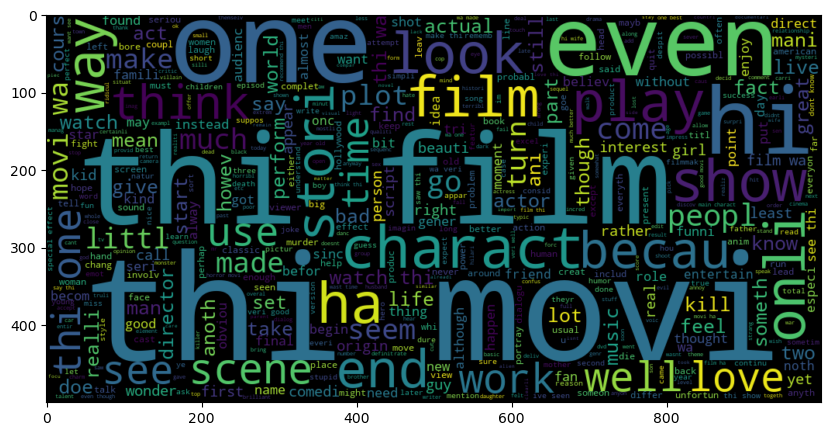

In [98]:
# For all reivews 
plt.figure(figsize=(10,10))
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
all_words =WC.generate(string_texts)
plt.imshow(all_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

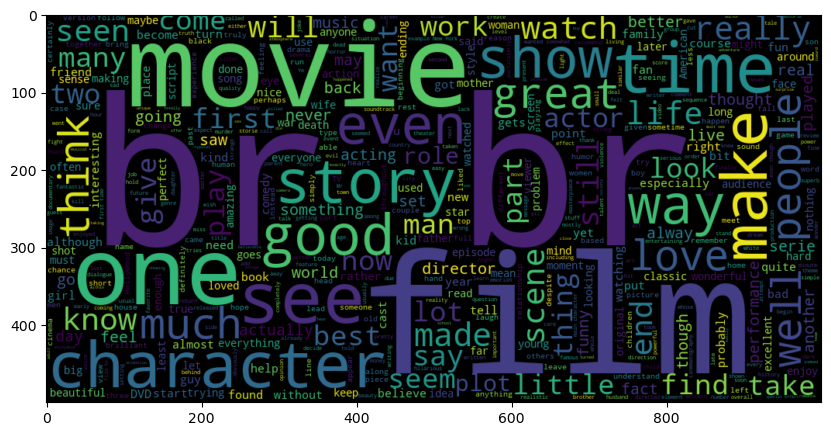

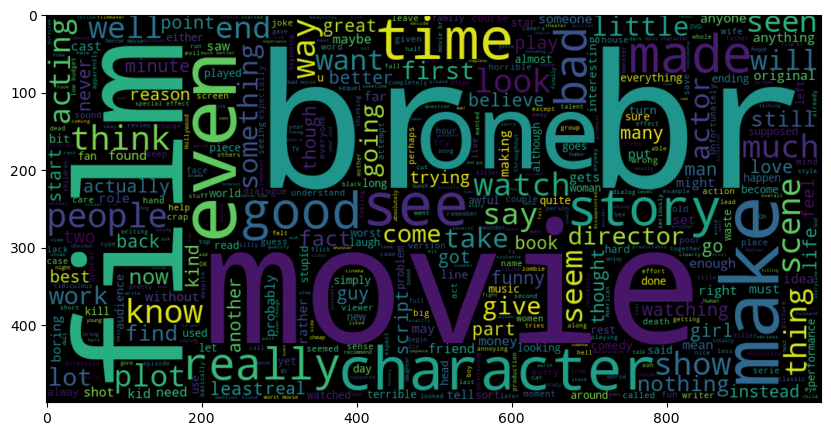

In [99]:
# For positive reviews
plt.figure(figsize=(10,10))
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
all_words =WC.generate(pos_string_texts)
plt.imshow(all_words,interpolation='bilinear')
plt.show

# For negative reviews
plt.figure(figsize=(10,10))
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
all_words =WC.generate(neg_string_texts)
plt.imshow(all_words,interpolation='bilinear')
plt.show


Word clouds show nothing informative when plotting bags of words. We believe plotting tf-idf will be more informative if we have enough computational power.

In [100]:
# #Attempt to convert Tf-idf vector back to word for wordcloud, but it exceeds its computational capacity

# # Get the feature names from the TfidfVectorizer
# feature_names = tv.get_feature_names_out()

# # Create a dictionary mapping feature indices to feature names
# feature_dict = dict(zip(range(len(feature_names)), feature_names))

# # Create a dense matrix of the tf-idf values
# dense_matrix = tv_train_reviews.todense()

# # Get the tf-idf scores for each feature
# tfidf_scores = dense_matrix.mean(axis=0).tolist()[0]

# # Create a dictionary mapping feature names to tf-idf scores
# tfidf_dict = dict(zip(feature_names, tfidf_scores))

# # Create a WordCloud object with the desired parameters
# wordcloud = WordCloud(width=800, height=800, background_color='white', colormap='inferno', stopwords=None, min_font_size=10)

# # Generate the word cloud from the tf-idf dictionary
# wordcloud.generate_from_frequencies(tfidf_dict)

# # Display the word cloud
# plt.figure(figsize=(8,8), facecolor=None)
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.tight_layout(pad=0)
# plt.show()

## Unigram, Bigram, Trigram analysis 

In [134]:
count_good=imdb_data[imdb_data['sentiment']=='positive']
count_bad=imdb_data[imdb_data['sentiment']=='negative']

In [144]:
from nltk.util import ngrams
from nltk import FreqDist

count_good['review'] = count_good['review'].apply(denoise_text)
count_bad['review'] = count_bad['review'].apply(denoise_text)


def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())

    return words
corpus = get_corpus(imdb_data.review)
pos_corpus = get_corpus(count_good.review)
neg_corpus = get_corpus(count_bad.review)

def top_n_grams(corpus, n):
    p = ' '.join(corpus)
    # Tokenize the text into bigrams
    bigrams = list(ngrams(p.split(), n))

    # Calculate the frequency of each bigram
    freq_dist = FreqDist(bigrams)

    # Sort the bigrams based on their frequency
    sorted_ngrams = sorted(freq_dist.items(), key=lambda x: x[1], reverse=True)

    # Get the top 10 bigrams
    top_n_bigrams = sorted_ngrams[:20]


    return top_n_bigrams

/var/folders/0h/xyv81g2n7sj6zr0c9cw30gkc0000gn/T/ipykernel_9162/920115542.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_good['review'] = count_good['review'].apply(denoise_text)
/var/folders/0h/xyv81g2n7sj6zr0c9cw30gkc0000gn/T/ipykernel_9162/920115542.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_bad['review'] = count_bad['review'].apply(denoise_text)


## Unigram

Text(0.5, 1.0, 'Top 20 Commmon Words Unigram for Good reviews')

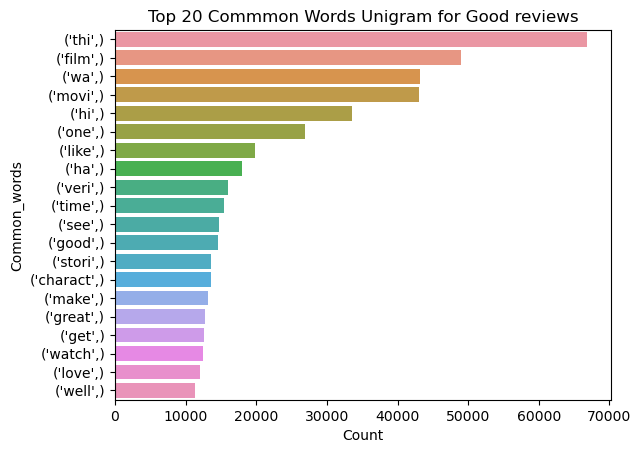

In [150]:
most_common_uni = top_n_grams(pos_corpus,1)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())

fig = sns.barplot(temp, x="Count", y="Common_words", orientation='horizontal')
plt.title("Top 20 Commmon Words Unigram for Good reviews")

Text(0.5, 1.0, 'Top 20 Commmon Words Unigram for Good reviews')

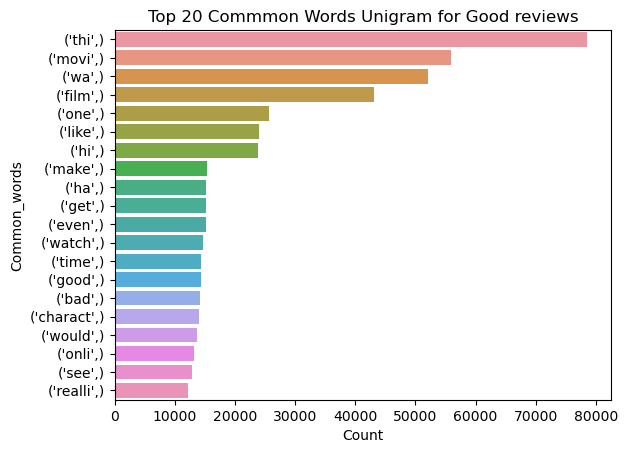

In [151]:
most_common_uni = top_n_grams(neg_corpus,1)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())

fig = sns.barplot(temp, x="Count", y="Common_words", orientation='horizontal')
plt.title("Top 20 Commmon Words Unigram for Good reviews")

For unigram, we can see that there isn't much difference between good and bad reviews. 

## Bigram

Text(0.5, 1.0, 'Top 20 Commmon Words Bigram for Good reviews')

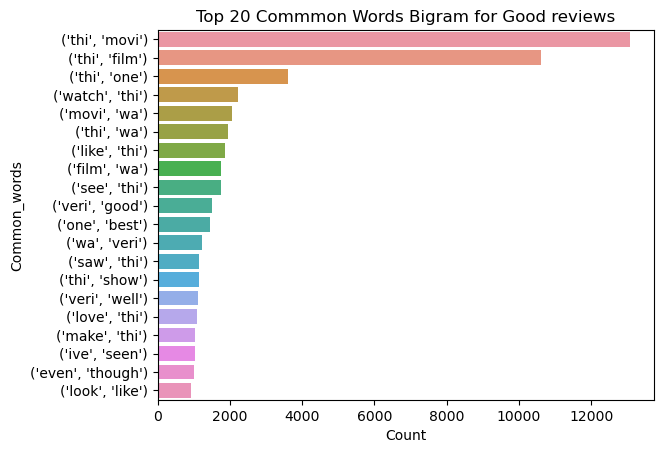

In [145]:
most_common_uni = top_n_grams(pos_corpus,2)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())

fig = sns.barplot(temp, x="Count", y="Common_words", orientation='horizontal')
plt.title("Top 20 Commmon Words Bigram for Good reviews")

Text(0.5, 1.0, 'Top 20 Commmon Words Bigram for Bad reviews')

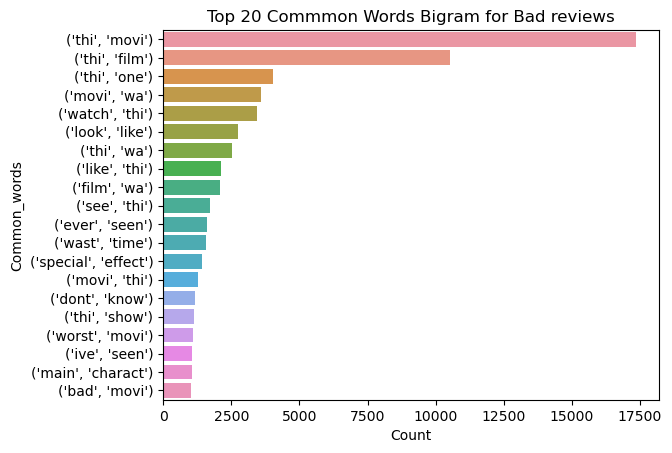

In [146]:
most_common_uni = top_n_grams(neg_corpus,2)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())

fig = sns.barplot(temp, x="Count", y="Common_words", orientation='horizontal')
plt.title("Top 20 Commmon Words Bigram for Bad reviews")

In Bigram, though the top 9 common words are the same for both good and bad reviews, but we can see some indicators to show negative and positive comments. 
- Example good reviews bigrams: (very, good), (very, well), (love, this)
- Example bad reviews bigrams: (waste time), (worst, movie), (bad, movie)

We can see that 'good' and 'bad' are the key words.

## Trigram

Text(0.5, 1.0, 'Top 20 Commmon Words Trigram for Good reviews')

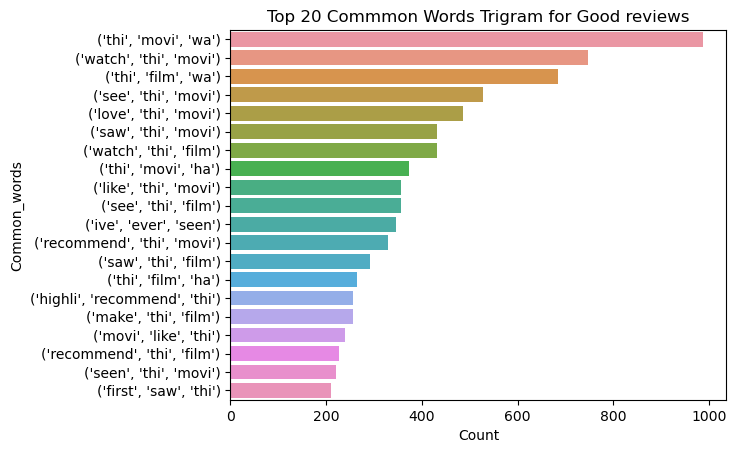

In [148]:
most_common_uni = top_n_grams(pos_corpus,3)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())

fig = sns.barplot(temp, x="Count", y="Common_words", orientation='horizontal')
plt.title("Top 20 Commmon Words Trigram for Good reviews")

Text(0.5, 1.0, 'Top 20 Commmon Words Trigram for Bad reviews')

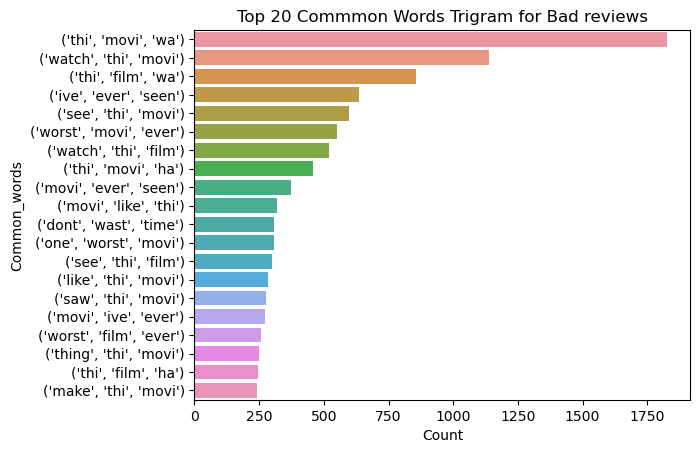

In [149]:
most_common_uni = top_n_grams(neg_corpus,3)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())

fig = sns.barplot(temp, x="Count", y="Common_words", orientation='horizontal')
plt.title("Top 20 Commmon Words Trigram for Bad reviews")

Trigram even shows even more difference between good and bad reviews. 
- Example good reviews bigrams: (love, this, movie),(like, this movie), (recommend, this movie), (highly, recommend, this), (recommend, this film)
- Example bad reviews bigrams: (worst, movie, ever), (don't, waste, time), (one, worst, movie), (worst, film, ever)

More than using keywords 'good' and 'bad', we see more information of such as strongrecommendation for good reviews. For bad reviews, it still maintains 'worst' as the main keyword.